# Imports required

* Torch - For coding neural networks
* Torchvision - Data, Preprocessing and utilities
* Tqdm - Progress bar
* Typing - Type hinting in Python
* Matplotlib - Plotting and visualizing the data


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as T
import torchvision.datasets as datasets
from torchvision.utils import save_image, make_grid

from tqdm.auto import tqdm
from typing import Union
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# Utility functions

* Save-Network - For saving a network by creating a checkpoint
* Load-Network - Loads a network given a checkpoint
* Show-Samples - Displays / Saves image samples
* Get-Noise    - Sample vectors from a gaussian distribution of `mean=0 and variance=1`

In [3]:
def save_network(filename: str, network: nn.Module, optimizer: optim.Optimizer, **kwargs):
    checkpoint = {'network': network.state_dict(), 'optimizer': optimizer.state_dict()}
    for param in kwargs:
        checkpoint[param] = kwargs[param]
    print(f'-> Saving Model at {filename}')
    torch.save(checkpoint, filename)


def load_network(filename: str, network: nn.Module, optimizer: optim.Optimizer, lr: float, **kwargs):
    checkpoint = torch.load(filename)
    network.load_state_dict(checkpoint['network'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    meta_data = {}
    for param in kwargs:
        if checkpoint.get(param, None) is not None:
            meta_data[param] = checkpoint[param]

    return meta_data


def show_samples(image_tensors: torch.Tensor, shape: tuple, n_samples: int, n_row: int,
                 normalize: bool = True, save: bool = False, factor=None):
    # Detach, put on CPU and reshape the tensors
    image_tensors = image_tensors.detach().cpu().view(-1, *shape)
    images = image_tensors[:n_samples]

    grid = make_grid(images, n_row, padding=1, normalize=normalize)
    if save:
        save_image(grid, f'Samples/Sample-{factor}.png')
        return
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
    
def get_noise(n_samples: int, noise_dim: int, device: Union[str, torch.device]):
    return torch.randn(n_samples, noise_dim, device=device)

# The Generator Model

* A simple feed forward fully connected network
* Input = (N, 100) i.e noise vectors of size 100
* Output = (N, 784) i.e flattened MNIST Image Tensors

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim: int, output_dim: int, hidden_dim: int = 64):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            # Block-1
            nn.Linear(noise_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Dropout(.5),

            # Block-2
            nn.Linear(hidden_dim, hidden_dim * 2, bias=False),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(inplace=True),

            nn.Dropout(.5),

            # Block-3
            nn.Linear(hidden_dim * 2, hidden_dim * 4, bias=False),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(inplace=True),

            # Final Block
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise: torch.Tensor):
        return self.generator(noise)

# The Discriminator Model

* A simple feed forward fully connected network
* Input = (N, 788) i.e flattened MNIST like images
* Uses leaky relu with 0.2 as the slope
* Output = (N, 1) i.e a sigmoid activated output denoting how real an image is
* 0 - Fake, 1 - Real

In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_features: int, hidden_dim: int = 64):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(

            # Block-1
            nn.Linear(in_features, hidden_dim * 4, bias=False),
            nn.LeakyReLU(.2),

            # Block-2
            nn.Linear(hidden_dim * 4, hidden_dim * 2, bias=False),
            nn.LeakyReLU(.2),

            # Block-2
            nn.Linear(hidden_dim * 2, hidden_dim, bias=False),
            nn.LeakyReLU(.2),

            # Final Block
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, images: torch.Tensor):
        return self.discriminator(images)

# Train-Fn - Function that trains the GAN

In [6]:
def train_fn(generator: Generator, discriminator: Discriminator,
             optimD: optim.Optimizer, optimG: optim.Optimizer, criterion: nn.Module,
             dataloader: DataLoader, device: Union[str, torch.device], noise_dim: int = 100):
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    gen_loss, disc_loss = 0.0, 0.0
    for batch_idx, (images, _) in loop:
        images = images.to(device)
        bs = len(images)
        noise = get_noise(bs, noise_dim, device=device)
        images = images.view(bs, -1)

        # Training the discriminator
        fakes = generator(noise)  # Generate fake samples
        real_predictions = discriminator(images)  # Discriminator predictions on real samples
        real_loss = criterion(real_predictions, torch.ones_like(real_predictions))  # Loss of Disc on real images
        fake_predictions = discriminator(fakes.detach())  # Discriminator predictions on fake samples
        fake_loss = criterion(fake_predictions, torch.zeros_like(fake_predictions))  # Loss of Disc on fake images

        lossD = (real_loss + fake_loss) / 2  # Complete loss of the discriminator
        # Updating the discriminator
        optimD.zero_grad()
        lossD.backward()
        optimD.step()

        # Training the generator
        fake_predictions = discriminator(fakes)
        lossG = criterion(fake_predictions, torch.ones_like(fake_predictions))
        # Updating the generator
        optimG.zero_grad()
        lossG.backward()
        optimG.step()

        gen_loss += lossG.item()
        disc_loss += lossD.item()

        loop.set_description(f'Step: [{batch_idx + 1}/{len(dataloader)}]')
        loop.set_postfix(generator_loss=gen_loss / (batch_idx + 1), discriminator_loss=disc_loss / (batch_idx + 1))

    return gen_loss / len(dataloader), disc_loss / len(dataloader), fakes

# Dataloading and transforming

In [7]:
tsfm = T.ToTensor()
bs = 64
dataset = datasets.MNIST('./Train', download=True, train=True, transform=tsfm)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

# Hyperparameters, model instantiation, optimizer instantiation and Loss Function

In [8]:
# Hyperparameters
n_epochs = 250
lr = 1e-5
noise_dim = 100
hidden_dim = 128
im_shape = 784
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(noise_dim, im_shape, hidden_dim).to(device)
discriminator = Discriminator(im_shape, hidden_dim).to(device)

optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr)
optimizer_gen = optim.Adam(generator.parameters(), lr=lr)
loss_fn = nn.BCELoss()

# The Training Loop

## Training Configuration

* BatchSize = 64
* Learning Rate = 1e-3
* Noise Dimension = 100
* Hidden Dim = Multiples of 64
* Optimizers = Adam for both Generator and Discriminator
* Loss Function = Binary Cross Entropy
* Saves fake samples for every epoch (Samples/)
* Saves both the models for every epoch (Models/)

In [9]:
gen_loss, disc_loss = [], []
print(f'Running on device: {device}')
for epoch in range(n_epochs):
    gen, disc, samples = train_fn(generator, discriminator, optimizer_disc, optimizer_gen, loss_fn, dataloader, device, noise_dim)
    
    samples = samples.detach().cpu()
    show_samples(samples, (1, 28, 28), 25, 5, save=True, factor=epoch)
    
    if epoch % 25 == 0:
        save_network(f'Models/Generator-{epoch}.pth.tar', generator, optimizer_gen, loss=gen, epoch=epoch)
        save_network(f'Models/Discriminator-{epoch}.pth.tar', discriminator, optimizer_disc, loss=disc, epoch=epoch)
    gen_loss.append(gen)
    disc_loss.append(disc)

Running on device: cuda



-> Saving Model at Models/Generator-0.pth.tar
-> Saving Model at Models/Discriminator-0.pth.tar



-> Saving Model at Models/Generator-25.pth.tar
-> Saving Model at Models/Discriminator-25.pth.tar



-> Saving Model at Models/Generator-50.pth.tar
-> Saving Model at Models/Discriminator-50.pth.tar



-> Saving Model at Models/Generator-75.pth.tar
-> Saving Model at Models/Discriminator-75.pth.tar



-> Saving Model at Models/Generator-100.pth.tar
-> Saving Model at Models/Discriminator-100.pth.tar



-> Saving Model at Models/Generator-125.pth.tar
-> Saving Model at Models/Discriminator-125.pth.tar



-> Saving Model at Models/Generator-150.pth.tar
-> Saving Model at Models/Discriminator-150.pth.tar



-> Saving Model at Models/Generator-175.pth.tar
-> Saving Model at Models/Discriminator-175.pth.tar



-> Saving Model at Models/Generator-200.pth.tar
-> Saving Model at Models/Discriminator-200.pth.tar



-> Saving Model at Models/Generator-225.pth.tar
-> Saving Model at Models/Discriminator-225.pth.tar


# Loss plot

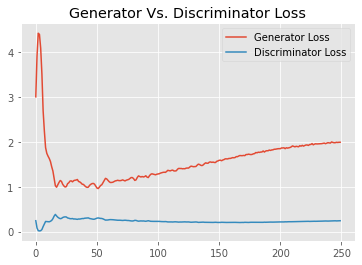

In [10]:
plt.plot(gen_loss)
plt.plot(disc_loss)
plt.legend(['Generator Loss', 'Discriminator Loss'])
plt.title('Generator Vs. Discriminator Loss')
plt.show()

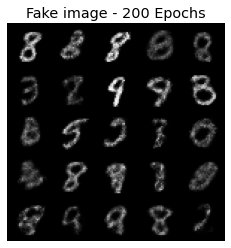

In [15]:
from PIL import Image

image = Image.open('Samples/Sample-199.png')
plt.grid(False)
plt.axis('off')
plt.title('Fake image - 200 Epochs')
plt.imshow(image)
plt.show()

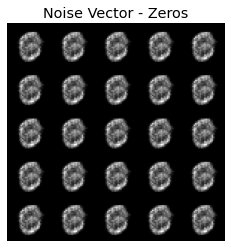

In [29]:
generator.eval()
inputs = torch.zeros(25, 100, device=device)
images = generator(inputs)
images = images.detach().cpu()
plt.title('Noise Vector - Zeros')
show_samples(images, (1, 28, 28), 25, 5, True)